In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from sotodlib import core
import sotodlib.io.load as io_load

from moby2.analysis import socompat
socompat.register_loaders()

import tools

#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

In [2]:
from sotodlib.core import FlagManager

import sotodlib.flags as flags
import sotodlib.sim_flags as sim_flags

import sotodlib.tod_ops.filters as filters

from sotodlib.tod_ops import fourier_filter, rfft, detrend_data

import tools
import importlib
importlib.reload(tools)
from tools import in_range

In [3]:
# LF:0,95  MFF:95,190 MFS:190, 285  UHF:285,380
obs_num1, obs_num2 = 0,1
obs_num = obs_num2 - obs_num1

det_set_num1, det_set_num2 = 0, 1
det_set_num = det_set_num2 - det_set_num1

det_num1, det_num2 = 0, 100
det_num = det_num2 - det_num1

n_glitch = 2
heights = np.arange(1, 10, 1)
signal_name = 'bad_signal'

# Choose observation
nersc_todsims = '/global/project/projectdirs/sobs/todsims/pipe-s0001/v4/context.yaml'
context = core.Context(nersc_todsims)
my_obs_list = context.obsdb.get()[obs_num1:obs_num2]

In [4]:
tod_num = obs_num * det_set_num * det_num
print('tod:', tod_num)
for my_obs in my_obs_list:
    print(my_obs['obs_id'])
print(context.obsfiledb.get_detsets(my_obs['obs_id'])[det_set_num1:det_set_num2])

tod: 100
CES-Atacama-LAT-Tier1DEC-035..-045_RA+040..+050-0-0_LF
['LF1_tube_LT6']


In [5]:
det_set_list = context.obsfiledb.get_detsets(my_obs['obs_id'])[det_set_num1:det_set_num2]
det_set = det_set_list[0]
dets = context.obsfiledb.get_dets(det_set)
tod = context.get_obs(my_obs, dets=dets[det_num1:det_num2])

tsamp = np.median(np.diff(tod.timestamps))
n_cut = int(10//tsamp)
print('Trimming in time...')

tod.restrict('samps', (n_cut, tod.samps.count-n_cut))
print('The TOD now has {} samples'.format(tod.samps.count))

Trimming in time...
The TOD now has 50038 samples


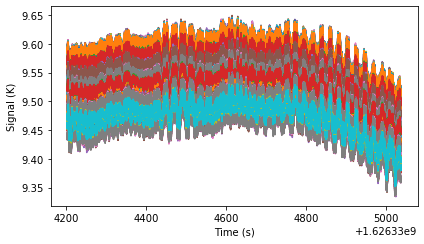

In [13]:
fig = plt.figure(figsize=(6,3.5))
for i in range(tod.dets.count):
    plt.plot(tod.timestamps, tod.signal[i])

plt.xlabel('Time (s)')
plt.ylabel('Signal (K)')
fig.tight_layout()

In [15]:
tod.timestamps.size

50038

Whats the Scan Rate?

In [6]:
if 'turnarounds' in tod.flags:
    tod.flags.move('turnarounds', None)

flags.get_turnaround_flags(tod, merge=True, name='turnarounds');
print( tod.flags.turnarounds )

tmsk = tod.flags.turnarounds.mask()

scan_rate = np.median( np.abs(np.diff(tod.boresight.az[~tmsk]))) / np.median(np.diff(tod.timestamps))
print( 'The scan rate is {} deg / s'.format(round(np.degrees(scan_rate),3) ))

turn = np.where( np.diff(tod.timestamps[tmsk]) > 0.005 )[0]
turn_time = np.median( np.diff(tod.timestamps[tmsk][turn]))

Ranges(n=50038:rngs=77)
The scan rate is 1.229 deg / s


In [7]:
ffts, freqs = rfft(tod)

In [18]:
print(tsamp)
tod.timestamps[1] - tod.timestamps[0]

0.016666650772094727


0.016666650772094727

so tsamp is the mean period, and 1/tsmap is frequency

hanning window

In [8]:
tsamp = np.median(np.diff(tod.timestamps))
norm_fact = (1.0/tsamp)*np.sum(np.abs(np.hanning(tod.samps.count))**2)
fmsk = freqs > 10
det_white_noise = 1e6*np.median(np.sqrt(np.abs(ffts[:,fmsk])**2/norm_fact),axis=1)

In [24]:
print(tsamp)
print(1.0/tsamp)
print(norm_fact)
np.sum(np.abs(np.hanning(tod.samps.count))**2)

0.016666650772094727
60.000057220513554
1125833.573678564


18763.875000000004

In [162]:
det_white_noise

array([255.13322, 256.99298, 255.17697, 257.79352, 255.63087, 256.75064,
       256.00043, 253.41281, 257.2558 , 260.64056, 257.06207, 254.3378 ,
       254.83302, 254.32677, 256.56635, 258.1652 , 253.38548, 254.62592,
       258.23172, 255.11143, 258.62408, 258.01965, 253.96306, 255.8098 ,
       258.88596, 257.98337, 256.67343, 259.01242, 256.8779 , 258.0514 ,
       256.7637 , 256.90866, 252.16374, 251.72307, 256.3395 , 256.4281 ,
       255.58241, 257.5533 , 256.0053 , 255.3438 , 252.2042 , 256.40125,
       257.5614 , 256.79   , 254.28328, 256.62402, 257.75323, 257.21774,
       258.9433 , 256.9551 , 254.43733, 254.33028, 255.91632, 259.15756,
       257.20007, 255.37732, 256.02814, 258.12177, 258.364  , 257.6409 ,
       255.50899, 258.71024, 257.55115, 256.8353 , 255.62555, 257.21704,
       258.9706 , 254.8488 , 255.48195, 258.77142, 255.01009, 257.38437,
       255.08786, 256.6992 , 257.77402, 258.22183, 259.04858, 253.88464,
       255.92674, 254.64949, 258.7536 , 256.10083, 

/global/common/software/cmb/cori/cmbenv-gcc_20200614/cmbenv_python/lib/python3.7/site-packages/ipykernel/__main__.py:20: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/global/common/software/cmb/cori/cmbenv-gcc_20200614/cmbenv_python/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


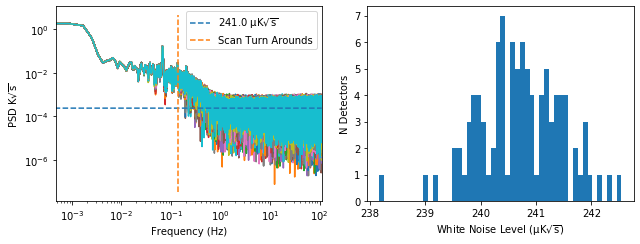

In [145]:
fig = plt.figure(figsize=(9,3.5))
plt.subplot(1,2,1)
for i in range(tod_num):
    plt.loglog( freqs, np.sqrt(np.abs(ffts[i])**2/norm_fact) );

plt.loglog(freqs, np.median(det_white_noise)*1e-6*np.ones_like(freqs), \
           '--', label='{} $\mathrm{{\mu K \sqrt{{s}}}}$'.format(round(np.median(det_white_noise))));
y0,y1 = plt.ylim()    
plt.loglog( [1/turn_time, 1/turn_time], [y0,y1], '--', label='Scan Turn Arounds' )

plt.legend()
plt.ylabel('PSD $\mathrm{K \sqrt{s}}$')
plt.xlabel('Frequency (Hz)')
plt.xlim(None, np.max(freqs))

plt.subplot(1,2,2)
plt.hist(det_white_noise,bins=50)
plt.ylabel('N Detectors');
plt.xlabel('White Noise Level ($\mathrm{\mu K \sqrt{s}}$)')
fig.tight_layout()
plt.show()

add time constant

In [146]:
## make some random time constants and add them to the TOD.
# the LAT timeconstants will be ~1 ms. So I'm intentionally making these too large
time_constants = np.linspace(0.001, 0.1, tod.dets.count)
if 'timeconst' in tod:
    tod.move('timeconst', None)
tod.wrap( 'timeconst', time_constants, [(0,tod.dets)] );

In [147]:
signal = tod.signal - tod.signal.mean(axis=1, keepdims=True)
tod.signal = signal

In [148]:
## filter the data and then take it's fft so we can see what it looks like.
filt_data = fourier_filter(tod, filters.tau_filter(tau_name='timeconst',do_inverse=False))
if 'filt_signal' in tod:
    tod.move('filt_signal', None)
tod.wrap('filt_signal', filt_data, [(0,tod.dets), (1,tod.samps)]);
filt_ffts, filt_freqs = rfft(tod, signal_name='filt_signal')

/global/common/software/cmb/cori/cmbenv-gcc_20200614/cmbenv_python/lib/python3.7/site-packages/ipykernel/__main__.py:34: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/global/common/software/cmb/cori/cmbenv-gcc_20200614/cmbenv_python/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


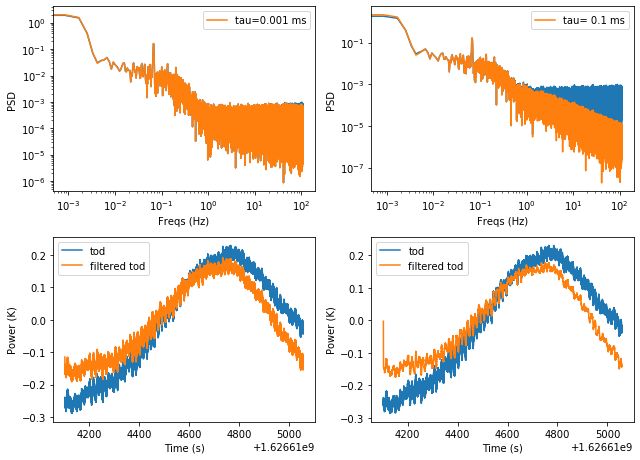

In [149]:
fig=plt.figure(figsize=(9.0,6.5))

plt.subplot(2,2,1)
plt.loglog( freqs, np.sqrt(np.abs(ffts[0])**2/norm_fact) )
plt.loglog( filt_freqs, np.sqrt(np.abs(filt_ffts[0])**2/norm_fact), \
           label='tau={} ms'.format(round(tod.timeconst[0],3)) )
plt.legend()
plt.xlabel('Freqs (Hz)')
plt.ylabel('PSD')

plt.subplot(2,2,2)
plt.loglog( freqs, np.sqrt(np.abs(ffts[tod.dets.count-1])**2/norm_fact) )
plt.loglog( filt_freqs, np.sqrt(np.abs(filt_ffts[tod.dets.count-1])**2/norm_fact), \
           label='tau= {} ms'.format(round(tod.timeconst[tod.dets.count-1],3)) )

plt.legend()
plt.xlabel('Freqs (Hz)')
plt.ylabel('PSD')

plt.subplot(2,2,3)
plt.plot(tod.timestamps, tod.signal[0], label='tod')
plt.plot(tod.timestamps, tod.filt_signal[0], label='filtered tod')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Power (K)')


plt.subplot(2,2,4)
plt.plot(tod.timestamps, tod.signal[-1], label='tod')
plt.plot(tod.timestamps, tod.filt_signal[-1], label='filtered tod')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Power (K)')
fig.tight_layout()